In [2]:
import os
import sys
import time, csv
#sys.path.append('../../contrib/torch')
import numpy as np
import pandas as pd

In [37]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import deepchem as dc

from torch_geometric.data import Data, Batch
from deepchem.models.torch_models import layers
from deepchem.feat import GraphData
import deepchem.models.torch_models.layers as torch_layers
from deepchem.models.torch_models.dmpnn import _MapperDMPNN
from deepchem.models.torch_models import DMPNN
from deepchem.models.torch_models import DMPNNModel

from typing import Union, List, Sequence, Optional

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
2025-01-25 05:50:16.585975: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-25 05:50:16.808473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737784216.887626   11409 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737784216.908708   11409 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 05:50:17.122308: I tensorflow/core/platform

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/usr/local/lib/python3.10/dist-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [4]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

In [5]:
data = pd.read_csv(r"virdis_solu_final.csv")
data['smiles']

0        CCCCN1CCCCC1C(=O)NC2=C(C=CC=C2C)C
1         CC1=C(C(=CC=C1)C)NC(=O)C2CCCCN2C
2      CCN1C=C(C(=O)C2=C1N=C(C=C2)C)C(=O)O
3                  C1=CC(=C(C=C1N)O)C(=O)O
4       CC12CCC(CC1CCC3C2CCC4(C3CCC4=O)C)O
                      ...                 
191                        C(C(=O)O)C(=O)O
192                 C(C(C(=O)O)O)(C(=O)O)O
193                                     CS
194                                     CO
195                     CC(=O)NC1=CC=CC=C1
Name: smiles, Length: 196, dtype: object

In [6]:
def get_smiles_sol(file_name):
    '''
    Return smiles and experimental solubiliy for each molecule
    '''    
    with open(file_name, 'r') as f:
        csv_reader = csv.reader(f, delimiter = ',')
        next(csv_reader)
        data = [(row[0],float(row[1])) for row in csv_reader]
    
    return data

In [7]:
def extract_descr(data):
    '''
    Return a list of descriptors for each smiles string
    '''  
    list_of_descr = []
    for mol in data:         
        m = Chem.MolFromSmiles(mol[0])
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(descr_names)
        each_mol = [i for i in calc.CalcDescriptors(m)]  
        each_mol.append(mol[0])
        each_mol.append(mol[1])
        list_of_descr.append(each_mol)
    
    return list_of_descr

In [8]:
# Getting descriptors names
descr_names = [i[0] for i in Descriptors._descList]

descriptors = extract_descr(get_smiles_sol('virdis_solu_final.csv'))

# Appending 'smiles' and 'sol' to the descriptors names
descr_names.append('smiles')
descr_names.append('sol')

In [9]:
# Writing data to .csv files
def write_to_csv(file_name, data):
    with open(file_name, 'w') as f:
        csv_writer = csv.writer(f, delimiter = ',')
        csv_writer.writerow(descr_names)
        csv_writer.writerows(data)

write_to_csv('rdkit_virdis_solubility.csv', descriptors)

In [10]:
data = pd.read_csv('rdkit_virdis_solubility.csv')

In [11]:
data.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,smiles,sol
0,12.692735,12.692735,0.045654,0.045654,0.891013,19.476190,288.435,260.211,288.220164,116,...,0,0,0,0,0,0,1,0,CCCCN1CCCCC1C(=O)NC2=C(C=CC=C2C)C,-3.497626
1,12.329587,12.329587,0.025700,0.025700,0.869904,20.722222,246.354,224.178,246.173213,98,...,0,0,0,0,0,0,0,0,CC1=C(C(=CC=C1)C)NC(=O)C2CCCCN2C,-1.546455
2,11.915193,11.915193,0.217590,-1.208634,0.849524,10.705882,232.239,220.143,232.084792,88,...,0,0,0,0,0,0,0,0,CCN1C=C(C(=O)C2=C1N=C(C=C2)C)C(=O)O,-3.365918
3,10.332243,10.332243,0.139630,-1.164352,0.517606,9.454545,153.137,146.081,153.042593,58,...,0,0,0,0,0,0,0,0,C1=CC(=C(C=C1N)O)C(=O)O,-1.957202
4,12.377281,12.377281,0.012444,-0.054130,0.732973,56.523810,290.447,260.207,290.224580,118,...,0,0,0,0,0,0,0,0,CC12CCC(CC1CCC3C2CCC4(C3CCC4=O)C)O,-4.383815


In [12]:
data.columns

Index(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons',
       ...
       'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole',
       'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea', 'smiles',
       'sol'],
      dtype='object', length=212)

In [13]:
for name in data.columns:
    print (name)

MaxAbsEStateIndex
MaxEStateIndex
MinAbsEStateIndex
MinEStateIndex
qed
SPS
MolWt
HeavyAtomMolWt
ExactMolWt
NumValenceElectrons
NumRadicalElectrons
MaxPartialCharge
MinPartialCharge
MaxAbsPartialCharge
MinAbsPartialCharge
FpDensityMorgan1
FpDensityMorgan2
FpDensityMorgan3
BCUT2D_MWHI
BCUT2D_MWLOW
BCUT2D_CHGHI
BCUT2D_CHGLO
BCUT2D_LOGPHI
BCUT2D_LOGPLOW
BCUT2D_MRHI
BCUT2D_MRLOW
AvgIpc
BalabanJ
BertzCT
Chi0
Chi0n
Chi0v
Chi1
Chi1n
Chi1v
Chi2n
Chi2v
Chi3n
Chi3v
Chi4n
Chi4v
HallKierAlpha
Ipc
Kappa1
Kappa2
Kappa3
LabuteASA
PEOE_VSA1
PEOE_VSA10
PEOE_VSA11
PEOE_VSA12
PEOE_VSA13
PEOE_VSA14
PEOE_VSA2
PEOE_VSA3
PEOE_VSA4
PEOE_VSA5
PEOE_VSA6
PEOE_VSA7
PEOE_VSA8
PEOE_VSA9
SMR_VSA1
SMR_VSA10
SMR_VSA2
SMR_VSA3
SMR_VSA4
SMR_VSA5
SMR_VSA6
SMR_VSA7
SMR_VSA8
SMR_VSA9
SlogP_VSA1
SlogP_VSA10
SlogP_VSA11
SlogP_VSA12
SlogP_VSA2
SlogP_VSA3
SlogP_VSA4
SlogP_VSA5
SlogP_VSA6
SlogP_VSA7
SlogP_VSA8
SlogP_VSA9
TPSA
EState_VSA1
EState_VSA10
EState_VSA11
EState_VSA2
EState_VSA3
EState_VSA4
EState_VSA5
EState_VSA6
EState_

In [14]:
data_df_1 = pd.DataFrame().assign(MolWt=data['MolWt'], HeavyAtomMolWt=data['HeavyAtomMolWt'], ExactMolWt = data['ExactMolWt'], 
                                  HeavyAtomCount=data['HeavyAtomCount'], NHOHCount=data['NHOHCount'], NOCount=data['NOCount'],
                                  NumAromaticCarbocycles=data['NumAromaticCarbocycles'],NumAromaticHeterocycles=data['NumAromaticHeterocycles'],NumAromaticRings=data['NumAromaticRings'],
                                  NumHAcceptors=data['NumHAcceptors'],NumHDonors=data['NumHDonors'],NumHeteroatoms=data['NumHeteroatoms'],NumRotatableBonds=data['NumRotatableBonds'],
                                  FpDensityMorgan1=data['FpDensityMorgan1'],FpDensityMorgan2=data['FpDensityMorgan2'],FpDensityMorgan3=data['FpDensityMorgan3'],
                                  NumSaturatedCarbocycles=data['NumSaturatedCarbocycles'],NumSaturatedHeterocycles=data['NumSaturatedHeterocycles'],NumSaturatedRingst=data['NumSaturatedRings'],
                                  RingCount=data['RingCount'],MolLogP=data['MolLogP'],smiles=data['smiles'],sol=data['sol'])
print(data_df_1)

       MolWt  HeavyAtomMolWt  ExactMolWt  HeavyAtomCount  NHOHCount  NOCount  \
0    288.435         260.211  288.220164              21          1        3   
1    246.354         224.178  246.173213              18          1        3   
2    232.239         220.143  232.084792              17          1        5   
3    153.137         146.081  153.042593              11          4        4   
4    290.447         260.207  290.224580              21          1        2   
..       ...             ...         ...             ...        ...      ...   
191  104.061         100.029  104.010959               7          2        4   
192  150.086         144.038  150.016438              10          4        6   
193   48.110          44.078   48.003371               2          0        0   
194   32.042          28.010   32.026215               2          1        1   
195  135.166         126.094  135.068414              10          1        2   

     NumAromaticCarbocycles  NumAromati

In [15]:
data_df_1.shape

(196, 23)

In [16]:
data_df_1.isna().sum()

MolWt                       0
HeavyAtomMolWt              0
ExactMolWt                  0
HeavyAtomCount              0
NHOHCount                   0
NOCount                     0
NumAromaticCarbocycles      0
NumAromaticHeterocycles     0
NumAromaticRings            0
NumHAcceptors               0
NumHDonors                  0
NumHeteroatoms              0
NumRotatableBonds           0
FpDensityMorgan1            0
FpDensityMorgan2            0
FpDensityMorgan3            0
NumSaturatedCarbocycles     0
NumSaturatedHeterocycles    0
NumSaturatedRingst          0
RingCount                   0
MolLogP                     0
smiles                      0
sol                         0
dtype: int64

In [17]:
data.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,sol
count,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,...,196.000000,196.000000,196.0,196.0,196.000000,196.000000,196.0,196.000000,196.000000,196.000000
mean,9.136557,9.136557,0.465960,-0.458590,0.543986,13.579641,200.771337,188.994194,200.390833,72.030612,...,0.015306,0.005102,0.0,0.0,0.025510,0.005102,0.0,0.321429,0.030612,-2.369432
std,3.009095,3.009095,0.610668,1.449079,0.170389,10.806431,112.122026,107.107877,111.674485,37.568933,...,0.123082,0.071429,0.0,0.0,0.158073,0.071429,0.0,1.573417,0.172706,2.453455
min,0.000000,0.000000,0.000000,-5.494070,0.104202,0.000000,16.043000,12.011000,16.031300,8.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-11.491461
25%,8.334838,8.334838,0.106440,-1.021528,0.419052,9.178030,117.853750,110.083250,117.789701,46.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-4.033750
50%,10.041871,10.041871,0.323349,-0.382381,0.527574,10.457516,174.196000,161.109500,174.089209,64.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-2.017963
75%,10.901479,10.901479,0.708333,0.428048,0.660191,13.282738,269.474250,254.124250,268.685957,94.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-0.622184
max,13.713427,13.713427,6.000000,6.000000,0.900534,80.952381,697.613000,682.493000,691.580818,206.000000,...,1.000000,1.000000,0.0,0.0,1.000000,1.000000,0.0,18.000000,1.000000,1.580816


In [55]:
train , test = train_test_split( data_df_1, test_size=0.2,random_state = 42 )
print(train.shape)
print(test.shape)

(156, 23)
(40, 23)


In [56]:
train.describe()

,MolWt,HeavyAtomMolWt,ExactMolWt,HeavyAtomCount,NHOHCount,NOCount,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,...,NumRotatableBonds,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRingst,RingCount,MolLogP,sol
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,...,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,194.934058,183.574673,194.565167,13.057692,1.185897,3.160256,0.737179,0.153846,0.891026,2.506410,...,2.544872,1.206257,1.714361,2.101051,0.179487,0.102564,0.282051,1.282051,1.956734,-2.272945
std,103.653720,99.191217,103.271830,6.730998,1.333463,2.159740,0.843282,0.396010,0.919844,1.686748,...,2.984569,0.395374,0.447842,0.540760,0.815077,0.324872,0.856059,1.253613,1.986686,2.395628
min,17.031000,14.007000,17.026549,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.333333,0.416667,0.500000,0.000000,0.000000,0.000000,0.000000,-2.122600,-11.491461
25%,115.648000,105.562000,115.579146,8.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.927198,1.380952,1.721014,0.000000,0.000000,0.000000,0.000000,0.672325,-3.974577
50%,174.196000,162.153000,174.089209,12.000000,1.000000,3.000000,1.000000,0.000000,1.000000,2.000000,...,2.000000,1.166667,1.777778,2.226496,0.000000,0.000000,0.000000,1.000000,1.665800,-1.998262
75%,257.401250,245.910250,257.011931,18.000000,2.000000,4.000000,1.000000,0.000000,2.000000,3.000000,...,4.000000,1.500000,2.074405,2.500000,0.000000,0.000000,0.000000,2.000000,3.111750,-0.600618
max,502.780000,490.639000,502.402210,36.000000,6.000000,11.000000,4.000000,2.000000,4.000000,8.000000,...,24.000000,2.000000,2.500000,3.125000,6.000000,2.000000,6.000000,6.000000,9.842000,1.580816


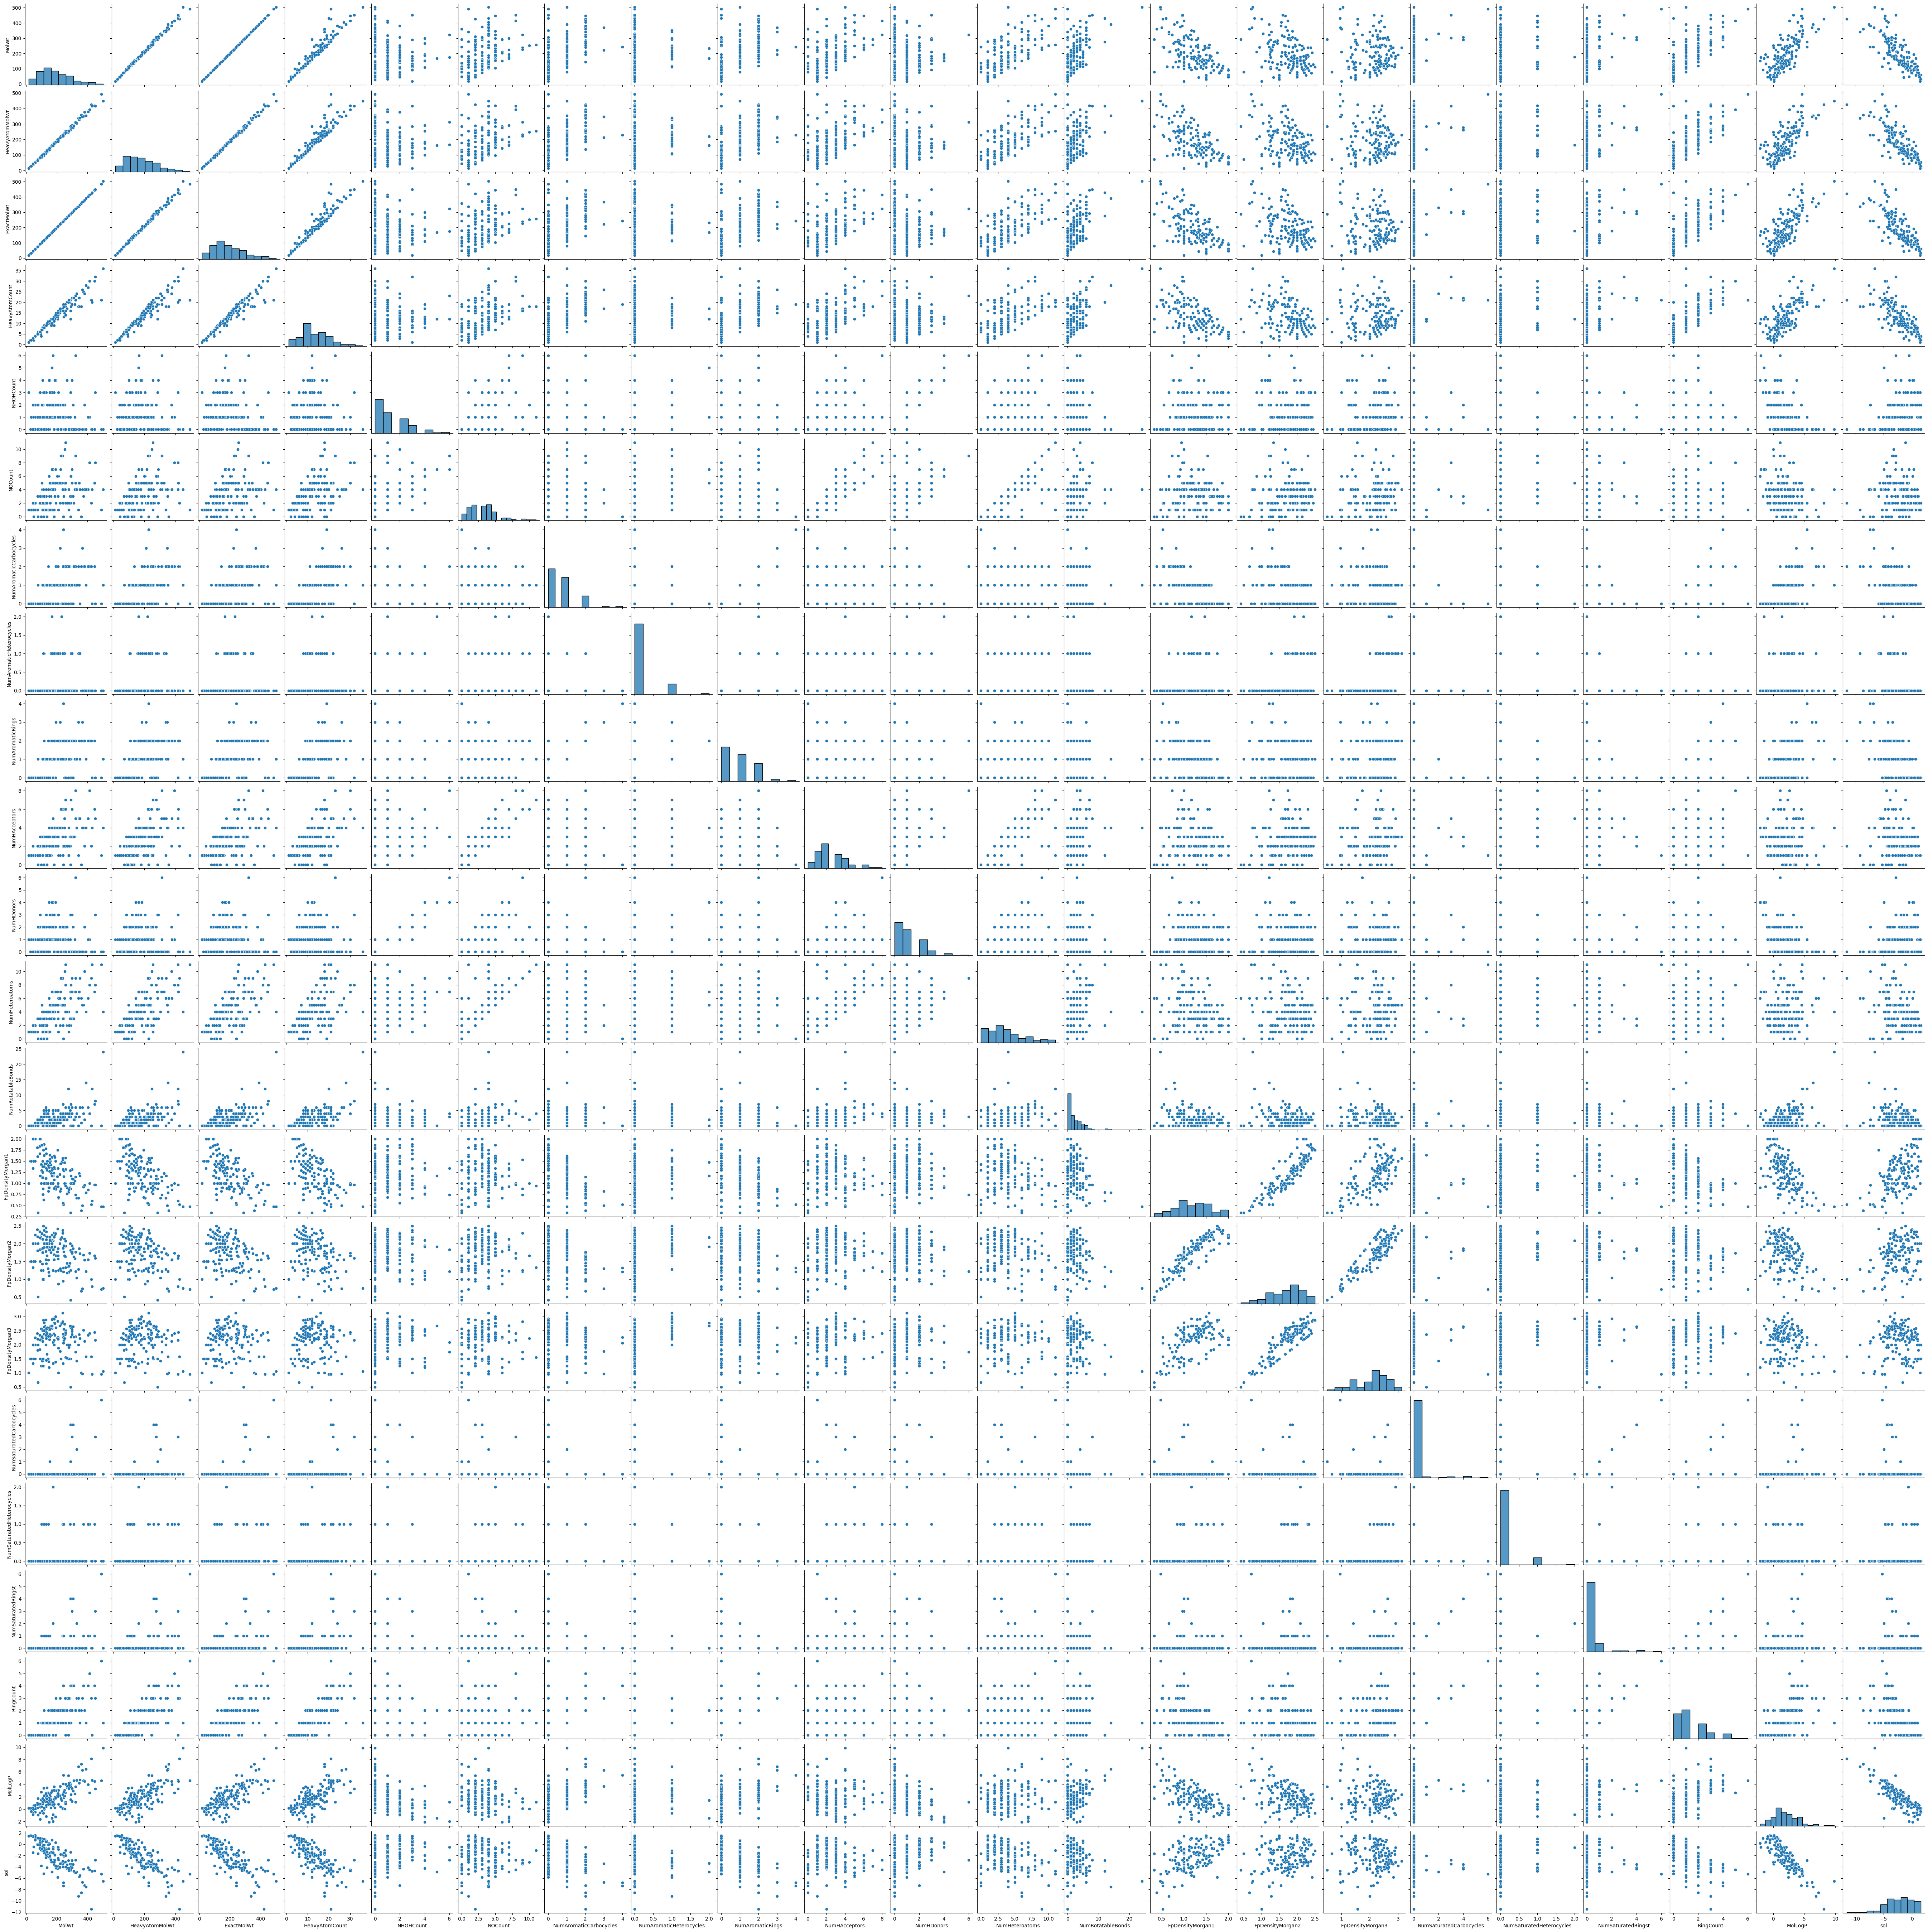

In [21]:
sns.pairplot(train)
plt.show()

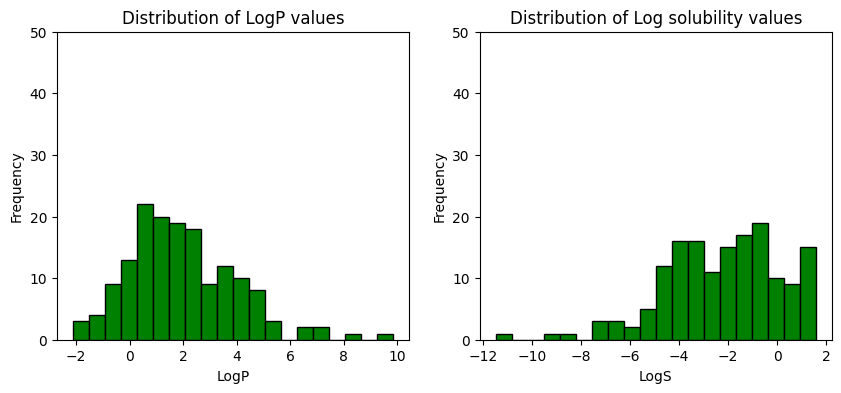

In [25]:
plt.figure(figsize=(10,4))

ytick = [0, 10 , 20 ,30, 40, 50]
plt.subplot(1,2,1)
plt.hist(train['MolLogP'], color = "green", edgecolor = 'black', bins = 20)
plt.title("Distribution of LogP values")
plt.xlabel("LogP")
plt.ylabel("Frequency")
plt.yticks(ytick)

plt.subplot(1,2,2)
plt.hist(train['sol'], color = "green", edgecolor = 'black', bins = 20)
plt.title("Distribution of Log solubility values")
plt.xlabel("LogS")
plt.ylabel("Frequency")
plt.yticks(ytick)

plt.show()

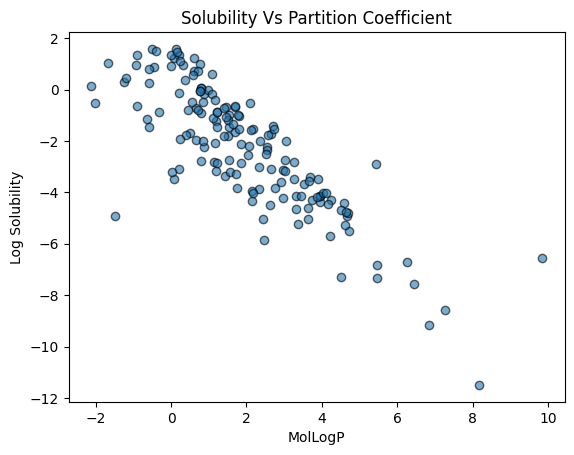

In [26]:
plt.scatter(train['MolLogP'], train['sol'], alpha = 0.6, edgecolor = "black")
plt.xlabel('MolLogP')
plt.ylabel('Log Solubility')
plt.title('Solubility Vs Partition Coefficient')
plt.show()

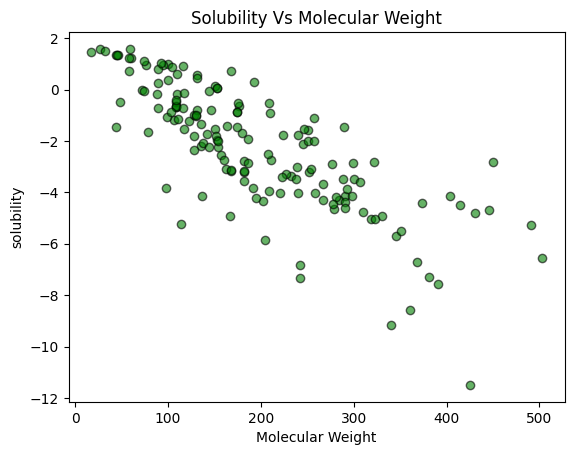

In [29]:
plt.scatter(train['MolWt'], train['sol'], alpha = 0.6, color = "green",  edgecolor = "black")
plt.xlabel('Molecular Weight')
plt.ylabel('solubility')
plt.title('Solubility Vs Molecular Weight')
plt.show()

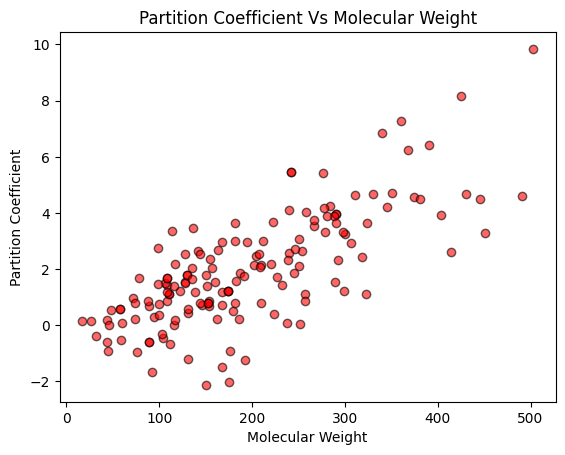

In [30]:
plt.scatter(train['MolWt'], train['MolLogP'], alpha = 0.6, color = "red", edgecolor = "black")
plt.xlabel('Molecular Weight')
plt.ylabel('Partition Coefficient')
plt.title('Partition Coefficient Vs Molecular Weight')
plt.show()

In [38]:
pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 3.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 KB 1.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [39]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [45]:
data_df_2 = pd.DataFrame().assign(MolWt=data['MolWt'], HeavyAtomMolWt=data['HeavyAtomMolWt'], ExactMolWt = data['ExactMolWt'], HeavyAtomCount=data['HeavyAtomCount'], NumAromaticRings=data['NumAromaticRings'],
                                  NumHAcceptors=data['NumHAcceptors'],NumHDonors=data['NumHDonors'],NumHeteroatoms=data['NumHeteroatoms'],NumRotatableBonds=data['NumRotatableBonds'],
                                  FpDensityMorgan1=data['FpDensityMorgan1'],FpDensityMorgan2=data['FpDensityMorgan2'],FpDensityMorgan3=data['FpDensityMorgan3'],
                                  RingCount=data['RingCount'],MolLogP=data['MolLogP'],sol=data['sol'])
print(data_df_2)

       MolWt  HeavyAtomMolWt  ExactMolWt  HeavyAtomCount  NumAromaticRings  \
0    288.435         260.211  288.220164              21                 1   
1    246.354         224.178  246.173213              18                 1   
2    232.239         220.143  232.084792              17                 2   
3    153.137         146.081  153.042593              11                 1   
4    290.447         260.207  290.224580              21                 0   
..       ...             ...         ...             ...               ...   
191  104.061         100.029  104.010959               7                 0   
192  150.086         144.038  150.016438              10                 0   
193   48.110          44.078   48.003371               2                 0   
194   32.042          28.010   32.026215               2                 0   
195  135.166         126.094  135.068414              10                 1   

     NumHAcceptors  NumHDonors  NumHeteroatoms  NumRotatableBon

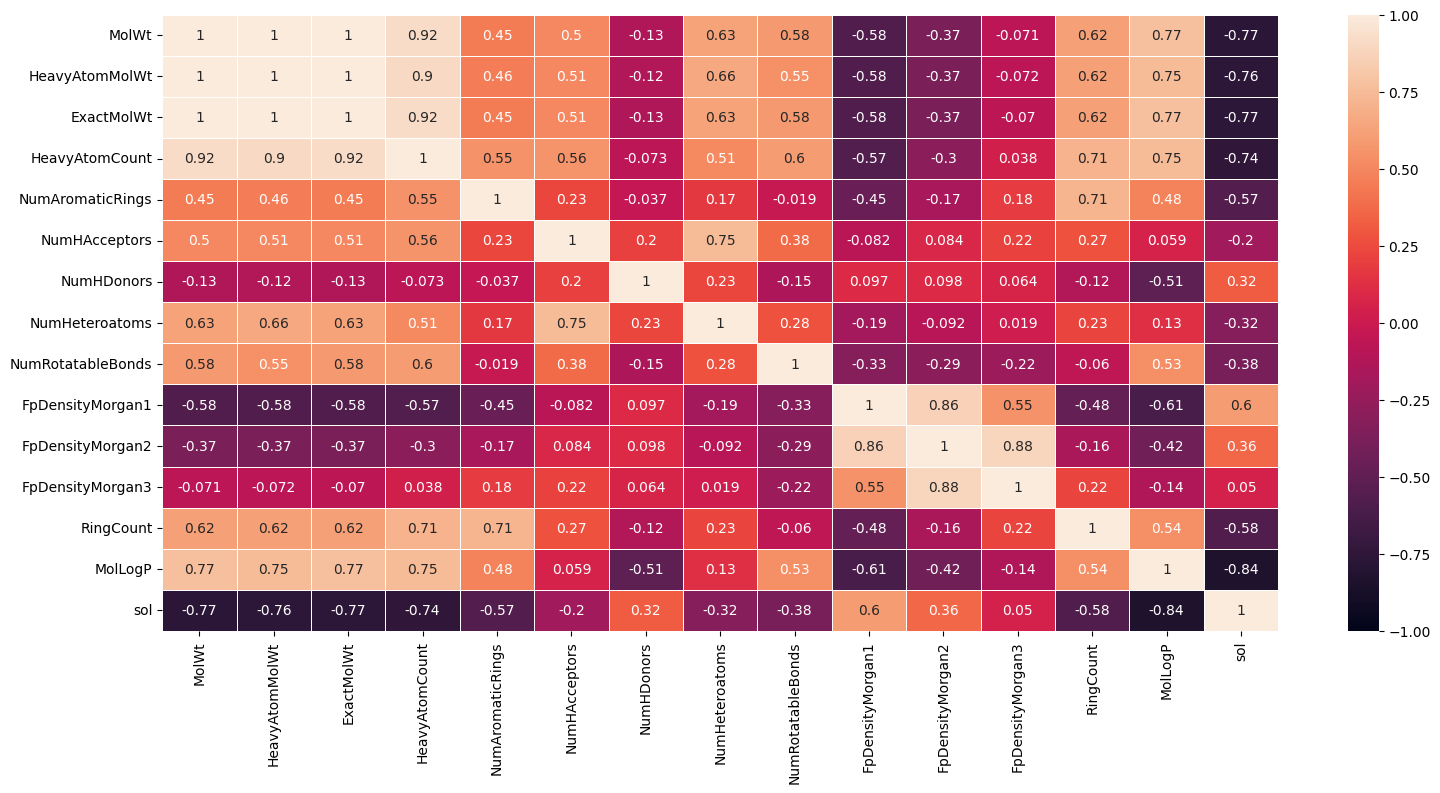

In [50]:
corr = data_df_2.corr()
#fig, ax = plt.subplots(figsize=(15, 10))  # Set the figure size
#sns.heatmap(df, ax=ax)
fig, ax = plt.subplots(figsize=(15, 10))
fig.set_size_inches(18, 8)
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax, vmin = -1)
plt.show()



In [51]:
corr['sol']

MolWt               -0.765749
HeavyAtomMolWt      -0.762296
ExactMolWt          -0.765615
HeavyAtomCount      -0.742602
NumAromaticRings    -0.569536
NumHAcceptors       -0.201751
NumHDonors           0.316004
NumHeteroatoms      -0.324765
NumRotatableBonds   -0.383748
FpDensityMorgan1     0.596322
FpDensityMorgan2     0.361666
FpDensityMorgan3     0.049733
RingCount           -0.583423
MolLogP             -0.836473
sol                  1.000000
Name: sol, dtype: float64

In [54]:
train2 , test2 = train_test_split( data_df_2, test_size=0.2,random_state = 42 )
print(train2.shape)
print(test2.shape)

(156, 15)
(40, 15)


In [57]:
train_x = train2.iloc[:,:-1]
train_y = train2.iloc[:,-1]

In [58]:
test_x = test2.iloc[:,:-1]
test_y = test2.iloc[:,-1]

In [59]:
print("train x : \n", train_x.head())
print("train y : \n",train_y.head())
print("test x : \n",test_x.head())
print("test y : \n",test_y.head())

train x : 
        MolWt  HeavyAtomMolWt  ExactMolWt  HeavyAtomCount  NumAromaticRings  \
5    168.152         160.088  168.053492              12                 1   
65   373.953         349.761  373.137946              25                 2   
136  122.123         116.075  122.036779               9                 1   
97   128.175         116.079  128.094963               9                 0   
168  179.175         170.103  179.058243              13                 1   

     NumHAcceptors  NumHDonors  NumHeteroatoms  NumRotatableBonds  \
5                4           1               5                  2   
65               4           0               5                  4   
136              2           1               2                  1   
97               2           0               3                  1   
168              2           2               4                  3   

     FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  RingCount  MolLogP  
5            1.583333   

#### Linear Regression Model

In [62]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(train_x, train_y)
pred_mod1 = model1.predict(test_x)

In [63]:
mean_squared_error(test_y, pred_mod1)

3.7050416560327077

In [64]:
r2_lin = r2_score(test_y, pred_mod1)
r2_lin

0.4652159763929613

#### Decision Tree Regressor

In [66]:
from sklearn.tree import DecisionTreeRegressor 
model2 = DecisionTreeRegressor()
model2.fit(train_x, train_y)
pred_mod2 = model2.predict(test_x)

In [67]:
r2_dt = r2_score(test_y, pred_mod2)
r2_dt

0.464152879169916

#### K Nearest Regressor

In [68]:
from sklearn.neighbors import KNeighborsRegressor
model3 = KNeighborsRegressor()
model3.fit(train_x, train_y)
pred_mod3 = model3.predict(test_x)
r2_knn = r2_score(test_y, pred_mod3)
r2_knn

0.5243411814179857

#### Ridge Regressor

In [71]:
from sklearn.linear_model import Ridge
model4 = Ridge(alpha = 0.1)
model4.fit(train_x, train_y)
pred_mod4 = model4.predict(test_x)
r2_ridge = r2_score(test_y, pred_mod4)
r2_ridge

0.47776042638367955

#### Random Forest Regressor

In [73]:
from sklearn.ensemble import RandomForestRegressor
model5 = RandomForestRegressor()
model5.fit(train_x, train_y)
pred_mod5 = model5.predict(test_x)
r2_rf = r2_score(test_y, pred_mod5)
r2_rf

0.7212587665130142

In [74]:
r2 = [r2_lin, r2_dt, r2_knn, r2_ridge, r2_rf]
model = ["Linear Reg", "Decision Tree", "K N N", "Ridge Reg", "Random Forest"]

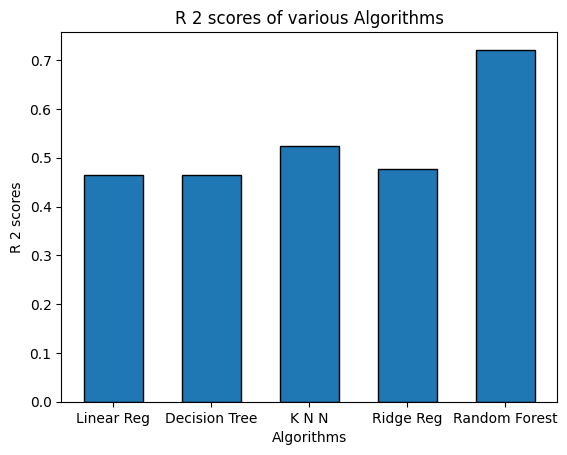

In [75]:
plt.bar(model, r2, width = 0.6, edgecolor = "black" )
plt.title("R 2 scores of various Algorithms")
plt.xlabel("Algorithms")
plt.ylabel("R 2 scores")
plt.show()

#### GLossary

In [ ]:
MolWt
HeavyAtomMolWt
ExactMolWt

HeavyAtomCount

NHOHCount
NOCount

NumAromaticCarbocycles
NumAromaticHeterocycles
NumAromaticRings

NumHAcceptors
NumHDonors

NumHeteroatoms
NumRotatableBonds

FpDensityMorgan1
FpDensityMorgan2
FpDensityMorgan3

NumSaturatedCarbocycles
NumSaturatedHeterocycles
NumSaturatedRings
RingCount
MolLogP